# Algorithmic_Trading_Machine_Learning_Quant_Strategies

All Packages Needed:
- pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [50]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt 
import statsmodels.api as sm 
import pandas as pd 
import numpy as np 
import datetime as dt 
import yfinance as yf 
import pandas_ta 
import warnings
warnings.filterwarnings('ignore')

# 1. Download/Load SP500 stock prices data.

In [51]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.','-')  # some tickers with '.' could cause issues later
 
symbols_list = sp500['Symbol'].unique().tolist() # not suvivorship-bias free

end_date = '2024-01-03'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date)
df

[*********************100%%**********************]  503 of 503 completed


Adj Close                                                 \
                     A        AAL        AAPL        ABBV        ABNB   
Date                                                                    
2016-01-05   38.003220  38.722759   23.376621   40.223888         NaN   
2016-01-06   38.171925  39.401272   22.919142   40.230888         NaN   
2016-01-07   36.550579  38.655865   21.951851   40.111710         NaN   
2016-01-08   36.166317  38.579414   22.067924   39.017941         NaN   
2016-01-11   35.557144  39.257919   22.425253   37.776943         NaN   
...                ...        ...         ...         ...         ...   
2023-12-26  139.573929  14.110000  193.050003  153.156693  138.720001   
2023-12-27  139.583923  13.990000  193.149994  153.414230  136.550003   
2023-12-28  139.534012  13.980000  193.580002  153.285461  137.000000   
2023-12-29  139.029999  13.740000  192.529999  153.503372  136.139999   
2024-01-02  138.750000  13.440000  185.639999  158.307480  134.479996   

                                                                       ...  \
                   ABT       ACGL         ACN        ADBE         ADI  ...   
Date                                                                   ...   
2016-01-05   36.770054  23.033333   89.741753   92.339996   45.841988  ...   
2016-01-06   36.461647  23.070000   89.566429   91.019997   43.890907  ...   
2016-01-07   35.587791  23.046667   86.936256   89.110001   42.771149  ...   
2016-01-08   34.842453  22.806667   86.094582   87.849998   42.397907  ...   
2016-01-11   34.893864  22.760000   86.997620   89.379997   43.407379  ...   
...                ...        ...         ...         ...         ...  ...   
2023-12-26  108.704857  73.510002  352.144104  598.260010  198.869995  ...   
2023-12-27  109.262161  73.540001  352.532684  596.080017  199.350006  ...   
2023-12-28  109.869232  74.059998  350.310791  595.520020  200.240005  ...   
2023-12-29  109.540817  74.269997  349.633270  596.599976  198.559998  ...   
2024-01-02  109.321869  75.550003  345.657806  580.070007  193.580002  ...   

             Volume                                                          \
               WYNN      XEL       XOM     XRAY      XYL       YUM      ZBH   
Date                                                                          
2016-01-05  4286100  2141200  11993500  1611200  1075400   5273420  2294737   
2016-01-06  3316100  5191900  18826900  1179700  1866000   5049330  2751233   
2016-01-07  5525600  5212200  21263800  1140400  1555400  11005453  1829589   
2016-01-08  5740000  3005400  19033600  1233700  1471500   5996184  1670969   
2016-01-11  4612400  3885400  21353000  1867600   852900   5891859  1626164   
...             ...      ...       ...      ...      ...       ...      ...   
2023-12-26  1150000  2147500  16835100  1335200   440300    627500  1870700   
2023-12-27  1142200  2865900  14558800  1202800  1007700   1050400  1058600   
2023-12-28  1233000  2421900  16329300  1152300   709100    882500   662200   
2023-12-29  1144800  2813300  17741400  1330600   698900   1196800   849600   
2024-01-02  3013600  4627600  23483000  1684400  1089400   1485300  1087400   

                                       
               ZBRA     ZION      ZTS  
Date                                   
2016-01-05   611300  2653600  3116700  
2016-01-06   881900  4164200  4670500  
2016-01-07  1210600  4234000  4324400  
2016-01-08  1034700  3401600  4946100  
2016-01-11  1034700  4627200  4306900  
...             ...      ...      ...  
2023-12-26   220000  1131600   814600  
2023-12-27   275700  1345100   766400  
2023-12-28   193900  1125900   880100  
2023-12-29   251300  1420600  1007200  
2024-01-02   452900  2256700  1642300  

[2012 rows x 3018 columns]

the above object has a multi-index column: e.g. Adj Close : [A,AAL,AAPL,...], Volume: [...]
also there's a ton of columns & this is inefficient. to fix this:

In [52]:
df = df.stack()
df

Adj Close       Close        High         Low        Open  \
Date                                                                          
2016-01-05 A      38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL    38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL   23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV   40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT    36.770054   42.919998   43.200001   42.610001   42.959999   
...                     ...         ...         ...         ...         ...   
2024-01-02 YUM   129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH   121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA  267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION   44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS   196.125183  196.570007  197.949997  195.050003  195.789993   

                      Volume  
Date                          
2016-01-05 A       2587200.0  
           AAL    10514200.0  
           AAPL  223164000.0  
           ABBV    7179600.0  
           ABT     8245200.0  
...                      ...  
2024-01-02 YUM     1485300.0  
           ZBH     1087400.0  
           ZBRA     452900.0  
           ZION    2256700.0  
           ZTS     1642300.0  

[994528 rows x 6 columns]

In [53]:
df.index.names = ['date','ticker']
df

Adj Close       Close        High         Low        Open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        Volume  
date       ticker               
2016-01-05 A         2587200.0  
           AAL      10514200.0  
           AAPL    223164000.0  
           ABBV      7179600.0  
           ABT       8245200.0  
...                        ...  
2024-01-02 YUM       1485300.0  
           ZBH       1087400.0  
           ZBRA       452900.0  
           ZION      2256700.0  
           ZTS       1642300.0  

[994528 rows x 6 columns]

In [54]:
df.columns = df.columns.str.lower()
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  
date       ticker               
2016-01-05 A         2587200.0  
           AAL      10514200.0  
           AAPL    223164000.0  
           ABBV      7179600.0  
           ABT       8245200.0  
...                        ...  
2024-01-02 YUM       1485300.0  
           ZBH       1087400.0  
           ZBRA       452900.0  
           ZION      2256700.0  
           ZTS       1642300.0  

[994528 rows x 6 columns]

# 2. Calculate features and technical indicators for each stock.

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

Garman-Klass Volatility = ((ln(High) - ln(Low))^2)/2 - (2ln(2) - 1)(ln(Adj Close) - ln(Open))^2

In [55]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol  
date       ticker                                 
2016-01-05 A         2587200.0         -0.001742  
           AAL      10514200.0         -0.000747  
           AAPL    223164000.0         -0.005303  
           ABBV      7179600.0         -0.051384  
           ABT       8245200.0         -0.009256  
...                        ...               ...  
2024-01-02 YUM       1485300.0          0.000080  
           ZBH       1087400.0          0.000092  
           ZBRA       452900.0          0.000197  
           ZION      2256700.0          0.000537  
           ZTS       1642300.0          0.000108  

[994528 rows x 7 columns]

RSI

In [56]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20)) #level 0 is date, and level 1 in the index is the ticker
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi  
date       ticker                                            
2016-01-05 A         2587200.0         -0.001742        NaN  
           AAL      10514200.0         -0.000747        NaN  
           AAPL    223164000.0         -0.005303        NaN  
           ABBV      7179600.0         -0.051384        NaN  
           ABT       8245200.0         -0.009256        NaN  
...                        ...               ...        ...  
2024-01-02 YUM       1485300.0          0.000080  54.181055  
           ZBH       1087400.0          0.000092  67.367561  
           ZBRA       452900.0          0.000197  63.392193  
           ZION      2256700.0          0.000537  63.435002  
           ZTS       1642300.0          0.000108  65.276723  

[994528 rows x 8 columns]

<Axes: xlabel='date'>

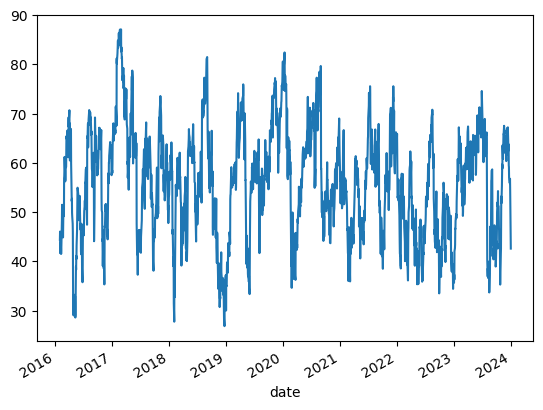

In [57]:
df.xs('AAPL', level=1)['rsi'].plot()  # level 0 is date, and level 1 in the index is the ticker

Bollinger Bands

- Now for each indicator, we'd like to normalize and scale

In [58]:
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
date,,,,,
2016-01-05,NaN,NaN,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN,NaN,NaN
2016-01-11,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2023-12-26,188.431228,193.831501,199.231774,5.572131,0.427643
2023-12-27,188.789699,193.969001,199.148303,5.340340,0.420935
2023-12-28,189.441568,194.179501,198.917435,4.879953,0.436734


In [59]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.051384        NaN       NaN   
           ABT       8245200.0         -0.009256        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000108  65.276723  5.194582   

                     bb_mid   bb_high  
date       ticker                      
2016-01-05 A            NaN       NaN  
           AAL          NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
...                     ...       ...  
2024-01-02 YUM     4.825425  4.825425  
           ZBH     4.753768  4.753768  
           ZBRA    5.422223  5.422223  
           ZION    3.620947  3.620947  
           ZTS     5.194582  5.194582  

[994528 rows x 11 columns]

ATR

In [60]:
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
              low=stock_data['low'],
              close=stock_data['close'],
              length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df


adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.051384        NaN       NaN   
           ABT       8245200.0         -0.009256        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000108  65.276723  5.194582   

                     bb_mid   bb_high       atr  
date       ticker                                
2016-01-05 A            NaN       NaN       NaN  
           AAL          NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
...                     ...       ...       ...  
2024-01-02 YUM     4.825425  4.825425 -0.069710  
           ZBH     4.753768  4.753768 -1.051946  
           ZBRA    5.422223  5.422223 -0.135093  
           ZION    3.620947  3.620947  0.186439  
           ZTS     5.194582  5.194582  0.399498  

[994528 rows x 12 columns]

MACD

In [61]:
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.051384        NaN       NaN   
           ABT       8245200.0         -0.009256        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000108  65.276723  5.194582   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-01-05 A            NaN       NaN       NaN       NaN  
           AAL          NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2024-01-02 YUM     4.825425  4.825425 -0.069710  0.669913  
           ZBH     4.753768  4.753768 -1.051946  0.948196  
           ZBRA    5.422223  5.422223 -0.135093  1.473233  
           ZION    3.620947  3.620947  0.186439  2.009179  
           ZTS     5.194582  5.194582  0.399498  2.052080  

[994528 rows x 13 columns]

- Dollar Volume

In [62]:
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6
df

adj close       close        high         low        open  \
date       ticker                                                               
2016-01-05 A        38.003220   40.549999   40.950001   40.340000   40.730000   
           AAL      38.722759   40.520000   41.490002   39.950001   41.180000   
           AAPL     23.376621   25.677500   26.462500   25.602501   26.437500   
           ABBV     40.223888   57.369999   58.250000   56.820000   57.990002   
           ABT      36.770054   42.919998   43.200001   42.610001   42.959999   
...                       ...         ...         ...         ...         ...   
2024-01-02 YUM     129.029999  129.029999  130.699997  128.949997  129.729996   
           ZBH     121.389999  121.389999  122.400002  120.720001  121.019997   
           ZBRA    267.980011  267.980011  270.739990  265.390015  268.559998   
           ZION     44.139999   44.139999   44.540001   43.000000   43.500000   
           ZTS     196.125183  196.570007  197.949997  195.050003  195.789993   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2016-01-05 A         2587200.0         -0.001742        NaN       NaN   
           AAL      10514200.0         -0.000747        NaN       NaN   
           AAPL    223164000.0         -0.005303        NaN       NaN   
           ABBV      7179600.0         -0.051384        NaN       NaN   
           ABT       8245200.0         -0.009256        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-02 YUM       1485300.0          0.000080  54.181055  4.825425   
           ZBH       1087400.0          0.000092  67.367561  4.753768   
           ZBRA       452900.0          0.000197  63.392193  5.422223   
           ZION      2256700.0          0.000537  63.435002  3.620947   
           ZTS       1642300.0          0.000108  65.276723  5.194582   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2016-01-05 A            NaN       NaN       NaN       NaN      98.321930  
           AAL          NaN       NaN       NaN       NaN     407.138835  
           AAPL         NaN       NaN       NaN       NaN    5216.820304  
           ABBV         NaN       NaN       NaN       NaN     288.791429  
           ABT          NaN       NaN       NaN       NaN     303.176448  
...                     ...       ...       ...       ...            ...  
2024-01-02 YUM     4.825425  4.825425 -0.069710  0.669913     191.648257  
           ZBH     4.753768  4.753768 -1.051946  0.948196     131.999485  
           ZBRA    5.422223  5.422223 -0.135093  1.473233     121.368147  
           ZION    3.620947  3.620947  0.186439  2.009179      99.610737  
           ZTS     5.194582  5.194582  0.399498  2.052080     322.096388  

[994528 rows x 14 columns]

# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.
- To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end fequency.

In [63]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2016-01-31 A           93.533661
           AAL        475.727892
           AAPL      5953.037617
           ABBV       458.087426
           ABT        317.479549
...                          ...
2024-01-31 YUM        191.648257
           ZBH        131.999485
           ZBRA       121.368147
           ZION        99.610737
           ZTS        322.096388

[47961 rows x 1 columns]

In [91]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume','volume','open',
                                                          'high','low','close']]
last_cols

['adj close',
 'garman_klass_vol',
 'rsi',
 'bb_low',
 'bb_mid',
 'bb_high',
 'atr',
 'macd']

In [101]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')],
          axis=1)).dropna()
data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A           91.918056   35.004208         -0.001913  48.218758   
           AAL        338.977819   39.288372         -0.000319  56.939335   
           AAPL      3548.073698   22.125885         -0.003013  49.176707   
           ABBV       353.627773   38.690922         -0.051766  48.001259   
           ABT        244.683668   33.398457         -0.009964  47.042147   
...                          ...         ...               ...        ...   
2024-01-31 YUM        191.648257  129.029999          0.000080  54.181055   
           ZBH        131.999485  121.389999          0.000092  67.367561   
           ZBRA       121.368147  267.980011          0.000197  63.392193   
           ZION        99.610737   44.139999          0.000537  63.435002   
           ZTS        322.096388  196.125183          0.000108  65.276723   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.522493  3.522493  3.522493 -0.931873 -0.230852  
           AAL     3.547833  3.547833  3.547833  0.977102  0.525167  
           AAPL    3.106253  3.106253  3.106253 -1.019133 -0.322383  
           ABBV    3.629341  3.629341  3.629341 -0.475529 -0.301063  
           ABT     3.479070  3.479070  3.479070 -0.795516 -0.388665  
...                     ...       ...       ...       ...       ...  
2024-01-31 YUM     4.825425  4.825425  4.825425 -0.069710  0.669913  
           ZBH     4.753768  4.753768  4.753768 -1.051946  0.948196  
           ZBRA    5.422223  5.422223  5.422223 -0.135093  1.473233  
           ZION    3.620947  3.620947  3.620947  0.186439  2.009179  
           ZTS     5.194582  5.194582  5.194582  0.399498  2.052080  

[47456 rows x 9 columns]

- Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [102]:
data['dollar_volume'] = (data.loc[:,'dollar_volume'].unstack('ticker').rolling(5*12).mean().stack())

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A                 NaN   35.004208         -0.001913  48.218758   
           AAL               NaN   39.288372         -0.000319  56.939335   
           AAPL              NaN   22.125885         -0.003013  49.176707   
           ABBV              NaN   38.690922         -0.051766  48.001259   
           ABT               NaN   33.398457         -0.009964  47.042147   
...                          ...         ...               ...        ...   
2024-01-31 YUM        187.227800  129.029999          0.000080  54.181055   
           ZBH        173.375525  121.389999          0.000092  67.367561   
           ZBRA       125.898913  267.980011          0.000197  63.392193   
           ZION        87.321279   44.139999          0.000537  63.435002   
           ZTS        304.986920  196.125183          0.000108  65.276723   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2016-02-29 A       3.522493  3.522493  3.522493 -0.931873 -0.230852  
           AAL     3.547833  3.547833  3.547833  0.977102  0.525167  
           AAPL    3.106253  3.106253  3.106253 -1.019133 -0.322383  
           ABBV    3.629341  3.629341  3.629341 -0.475529 -0.301063  
           ABT     3.479070  3.479070  3.479070 -0.795516 -0.388665  
...                     ...       ...       ...       ...       ...  
2024-01-31 YUM     4.825425  4.825425  4.825425 -0.069710  0.669913  
           ZBH     4.753768  4.753768  4.753768 -1.051946  0.948196  
           ZBRA    5.422223  5.422223  5.422223 -0.135093  1.473233  
           ZION    3.620947  3.620947  3.620947  0.186439  2.009179  
           ZTS     5.194582  5.194582  5.194582  0.399498  2.052080  

[47456 rows x 9 columns]

In [103]:
data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2016-02-29 A                 NaN   35.004208         -0.001913  48.218758   
           AAL               NaN   39.288372         -0.000319  56.939335   
           AAPL              NaN   22.125885         -0.003013  49.176707   
           ABBV              NaN   38.690922         -0.051766  48.001259   
           ABT               NaN   33.398457         -0.009964  47.042147   
...                          ...         ...               ...        ...   
2024-01-31 YUM        187.227800  129.029999          0.000080  54.181055   
           ZBH        173.375525  121.389999          0.000092  67.367561   
           ZBRA       125.898913  267.980011          0.000197  63.392193   
           ZION        87.321279   44.139999          0.000537  63.435002   
           ZTS        304.986920  196.125183          0.000108  65.276723   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2016-02-29 A       3.522493  3.522493  3.522493 -0.931873 -0.230852   
           AAL     3.547833  3.547833  3.547833  0.977102  0.525167   
           AAPL    3.106253  3.106253  3.106253 -1.019133 -0.322383   
           ABBV    3.629341  3.629341  3.629341 -0.475529 -0.301063   
           ABT     3.479070  3.479070  3.479070 -0.795516 -0.388665   
...                     ...       ...       ...       ...       ...   
2024-01-31 YUM     4.825425  4.825425  4.825425 -0.069710  0.669913   
           ZBH     4.753768  4.753768  4.753768 -1.051946  0.948196   
           ZBRA    5.422223  5.422223  5.422223 -0.135093  1.473233   
           ZION    3.620947  3.620947  3.620947  0.186439  2.009179   
           ZTS     5.194582  5.194582  5.194582  0.399498  2.052080   

                   dollar_vol_rank  
date       ticker                   
2016-02-29 A                   NaN  
           AAL                 NaN  
           AAPL                NaN  
           ABBV                NaN  
           ABT                 NaN  
...                            ...  
2024-01-31 YUM               255.0  
           ZBH               274.0  
           ZBRA              349.0  
           ZION              440.0  
           ZTS               154.0  

[47456 rows x 10 columns]

In [104]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2021-01-31 AAL      17.170000          0.003462  58.346031  2.739660   
           AAPL    129.669907          0.000365  51.602271  4.803911   
           ABBV     90.659622         -0.006942  44.922908  4.507562   
           ABT     117.258781          0.000595  75.566313  4.615893   
           ACN     232.008865         -0.001300  41.398456  5.464712   
...                       ...               ...        ...       ...   
2024-01-31 VRTX    410.910004          0.000153  67.425401  5.828718   
           VZ       38.235233          0.000498  65.390728  3.615283   
           WFC      49.330002          0.000169  67.725081  3.807954   
           WMT     159.289993          0.000046  55.513695  5.016623   
           XOM     102.360001          0.000166  49.345877  4.594588   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2021-01-31 AAL     2.739660  2.739660  0.424888  0.536249  
           AAPL    4.803911  4.803911  1.415046  1.132807  
           ABBV    4.507562  4.507562  0.326128  0.063553  
           ABT     4.615893  4.615893  1.597322  1.941807  
           ACN     5.464712  5.464712  0.375921 -0.606346  
...                     ...       ...       ...       ...  
2024-01-31 VRTX    5.828718  5.828718  1.109709  3.194646  
           VZ      3.615283  3.615283 -0.979204  0.647457  
           WFC     3.807954  3.807954 -0.735223  1.812122  
           WMT     5.016623  5.016623  0.027281 -0.081742  
           XOM     4.594588  4.594588  0.208639 -0.560152  

[5513 rows x 8 columns]

# 4. Calculate Monthly Returns for different time horizons as features.

 - To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the .pct_change(lag), that is,
   returns over various monthly periods as identified by lags.

In [105]:
g = df.xs('AAPL',level=1)
g

,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2016-01-05,23.376621,25.677500,26.462500,25.602501,26.437500,223164000.0,-0.005303,NaN,NaN,NaN,NaN,NaN,NaN,5216.820304
2016-01-06,22.919142,25.174999,25.592501,24.967501,25.139999,273829600.0,-0.002999,NaN,NaN,NaN,NaN,NaN,NaN,6275.939423
2016-01-07,21.951851,24.112499,25.032499,24.107500,24.670000,324377600.0,-0.004555,NaN,NaN,NaN,NaN,NaN,NaN,7120.688708
2016-01-08,22.067924,24.240000,24.777500,24.190001,24.637501,283192000.0,-0.004399,NaN,NaN,NaN,NaN,NaN,NaN,6249.459675
2016-01-11,22.425253,24.632500,24.764999,24.334999,24.742500,198957600.0,-0.003582,NaN,NaN,NaN,NaN,NaN,NaN,4461.674499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-26,193.050003,193.050003,193.889999,192.830002,193.610001,28919300.0,0.000012,55.893206,5.244295,5.244295,5.244295,0.341743,0.867847,5582.870953
2023-12-27,193.149994,193.149994,193.500000,191.089996,192.490005,48087700.0,0.000074,56.055415,5.246152,5.246152,5.246152,0.329818,0.728412,9288.138961
2023-12-28,193.580002,193.580002,194.660004,193.169998,194.139999,34049900.0,0.000026,56.775026,5.249548,5.249548,5.249548,0.276987,0.624660,6591.379704


In [107]:
def calculate_returns(df):

    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                    upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2023-01-31 AAL      16.139999          0.000185  59.776032  2.660994   
           AAPL    143.487961          0.000092  57.790448  4.816737   
           ABBV    142.006180          0.000032  38.838168  4.919439   
           ABT     108.349129          0.000066  52.707985  4.680500   
           ACN     274.805939          0.000173  51.894301  5.565104   
...                       ...               ...        ...       ...   
2024-01-31 VRTX    410.910004          0.000153  67.425401  5.828718   
           VZ       38.235233          0.000498  65.390728  3.615283   
           WFC      49.330002          0.000169  67.725081  3.807954   
           WMT     159.289993          0.000046  55.513695  5.016623   
           XOM     102.360001          0.000166  49.345877  4.594588   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2023-01-31 AAL     2.660994  2.660994 -1.151958  0.913990   0.262535   
           AAPL    4.816737  4.816737  0.951194  0.860472   0.110521   
           ABBV    4.919439  4.919439  0.596750 -2.187902  -0.077071   
           ABT     4.680500  4.680500  0.325321  0.335889   0.011481   
           ACN     5.565104  5.565104  1.021266 -0.123139   0.050035   
...                     ...       ...       ...       ...        ...   
2024-01-31 VRTX    5.828718  5.828718  1.109709  3.194646   0.009880   
           VZ      3.615283  3.615283 -0.979204  0.647457   0.031300   
           WFC     3.807954  3.807954 -0.735223  1.812122   0.002235   
           WMT     5.016623  5.016623  0.027281 -0.081742   0.010403   
           XOM     4.594588  4.594588  0.208639 -0.560152   0.023805   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2023-01-31 AAL      0.057593   0.044101   0.027569  -0.016633   -0.001685  
           AAPL    -0.012713  -0.019532  -0.019126  -0.009294   -0.014972  
           ABBV    -0.038027   0.006233   0.008150   0.003874    0.009520  
           ABT      0.016002   0.039241   0.004144  -0.001407   -0.010338  
           ACN     -0.035073  -0.004373  -0.013989  -0.006812   -0.017986  
...                      ...        ...        ...        ...         ...  
2024-01-31 VRTX     0.076156   0.043043   0.025961   0.021027    0.020236  
           VZ       0.007149   0.034386   0.025190   0.004471   -0.000968  
           WFC      0.051809   0.076542   0.013944   0.027069    0.006854  
           WMT      0.013372  -0.007250   0.000614   0.007214    0.009794  
           XOM     -0.001851  -0.008108  -0.004873  -0.012715   -0.007470  

[1795 rows x 14 columns]

# 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

 - We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression
 - The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown
 empirically explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
 - We can access the historical factor returns using pandas-datareader and estimate historical exposures using the RollingOLS rolling linear.

In [115]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
               'famafrench',
               start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()

In [116]:
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data

,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2010-01-31,-0.0336,0.0034,0.0043,-0.0127,0.0046
2010-02-28,0.0340,0.0151,0.0323,-0.0027,0.0143
2010-03-31,0.0631,0.0185,0.0221,-0.0065,0.0169
2010-04-30,0.0200,0.0498,0.0289,0.0069,0.0172
2010-05-31,-0.0789,0.0004,-0.0244,0.0130,-0.0021
...,...,...,...,...,...
2023-07-31,0.0321,0.0286,0.0411,-0.0057,0.0057
2023-08-31,-0.0239,-0.0365,-0.0106,0.0343,-0.0237
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083


In [117]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data


Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2023-01-31 AAL     0.0665  0.0441 -0.0401 -0.0244 -0.0447   0.262535
           AAPL    0.0665  0.0441 -0.0401 -0.0244 -0.0447   0.110521
           ABBV    0.0665  0.0441 -0.0401 -0.0244 -0.0447  -0.077071
           ABT     0.0665  0.0441 -0.0401 -0.0244 -0.0447   0.011481
           ACN     0.0665  0.0441 -0.0401 -0.0244 -0.0447   0.050035
...                   ...     ...     ...     ...     ...        ...
2023-11-30 VRTX    0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020160
           VZ      0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.091090
           WFC     0.0884 -0.0010  0.0165 -0.0389 -0.0099   0.131192
           WMT     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.047243
           XOM     0.0884 -0.0010  0.0165 -0.0389 -0.0099  -0.020506

[1520 rows x 6 columns]

In [118]:
factor_data.xs('AAPL', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2023-01-31,0.0665,0.0441,-0.0401,-0.0244,-0.0447,0.110521
2023-02-28,-0.0258,0.0066,-0.0081,0.0101,-0.0133,0.023183
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,0.118649
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.028987
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722,0.046058


In [119]:
factor_data.xs('MSFT', level=1).head()

,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,,,,,,
2023-01-31,0.0665,0.0441,-0.0401,-0.0244,-0.0447,0.033317
2023-02-28,-0.0258,0.0066,-0.0081,0.0101,-0.0133,0.009018
2023-03-31,0.0251,-0.0694,-0.0885,0.0224,-0.0237,0.152094
2023-04-30,0.0061,-0.0256,-0.0004,0.0242,0.0286,0.065765
2023-05-31,0.0035,-0.0038,-0.0772,-0.0181,-0.0722,0.071106


 - Filter out stocks with < 10 months of data

In [123]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks)]
factor_data

,,Mkt-RF,SMB,HML,RMW,CMA,return_1m
date,ticker,,,,,,
